# Baixando as bibliotecas

In [16]:
!pip install mlforecast

!pip install dill

# Importando as bibliotecas

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

import mlforecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

# Funcoes

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      non_zero_idx = y_true != 0
      return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Carregando os dados

In [19]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [20]:
dados = pd.read_parquet(bucket_uri)

In [21]:
dados['date'] = pd.to_datetime(dados['date'])

In [22]:
last_date = dados['date'].max()

first_day_of_last_month = last_date.replace(day=1)

dados = dados[dados['date'] < first_day_of_last_month]

In [23]:
dados.set_index('date', inplace=True)

# Criando a série de valor total

In [24]:
dados = dados.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1)

In [25]:
valor_total = dados.resample("MS").sum()

## Split em treino e teste

In [26]:
teste_size = 6
teste = valor_total.tail(teste_size)
train = valor_total.drop(teste.index)

In [27]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [28]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y'})

In [29]:
df_train['unique_id'] = 0
df_test['unique_id'] = 0

## Analisando o melhor modelo para a previsão

In [31]:
models={
    'lgb': AutoLightGBM(), 
    'ridge': AutoRidge(),
    'xgb': AutoXGBoost(),
    'linear_regression': AutoLinearRegression(),
    'lasso': AutoLasso(),
    'elastic_net': AutoElasticNet(),
    'rf' : AutoRandomForest()
        }

In [32]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=6,
)

In [33]:
auto_mlf.fit(
    df_train,
    n_windows=4,
    h=6,
    num_samples=6,
)

[I 2024-07-05 16:20:12,642] A new study created in memory with name: no-name-882726b9-a314-4f42-ab04-a840c2d3676f
[I 2024-07-05 16:20:12,825] Trial 0 finished with value: 0.05025303884766637 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 2}. Best is trial 0 with value: 0.05025303884766637.
[I 2024-07-05 16:20:13,011] Trial 1 finished with value: 0.0606956572236476 and parameters: {'n_estimators': 920, 'lambda_l1': 0.15574964948467418, 'lambda_l2': 0.00014233583723829364, 'num_leaves': 722, 'feature_fraction': 0.5591372129344666, 'bagging_fraction': 0.819960510663762, 'objective': 'l2', 'target_transforms_idx': 3, 'lags_idx': 0, 'lag_transforms_idx': 1}. Best is trial 0 with value: 0.05025303884766637.
[I 2024-07-05 16:20:13,181] Trial 2 finished

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'ridge': AutoModel(model=Ridge), 'xgb': AutoModel(model=XGBRegressor), 'linear_regression': AutoModel(model=LinearRegression), 'lasso': AutoModel(model=Lasso), 'elastic_net': AutoModel(model=ElasticNet), 'rf': AutoModel(model=RandomForestRegressor)})

In [34]:
preds = auto_mlf.predict(6)

In [35]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

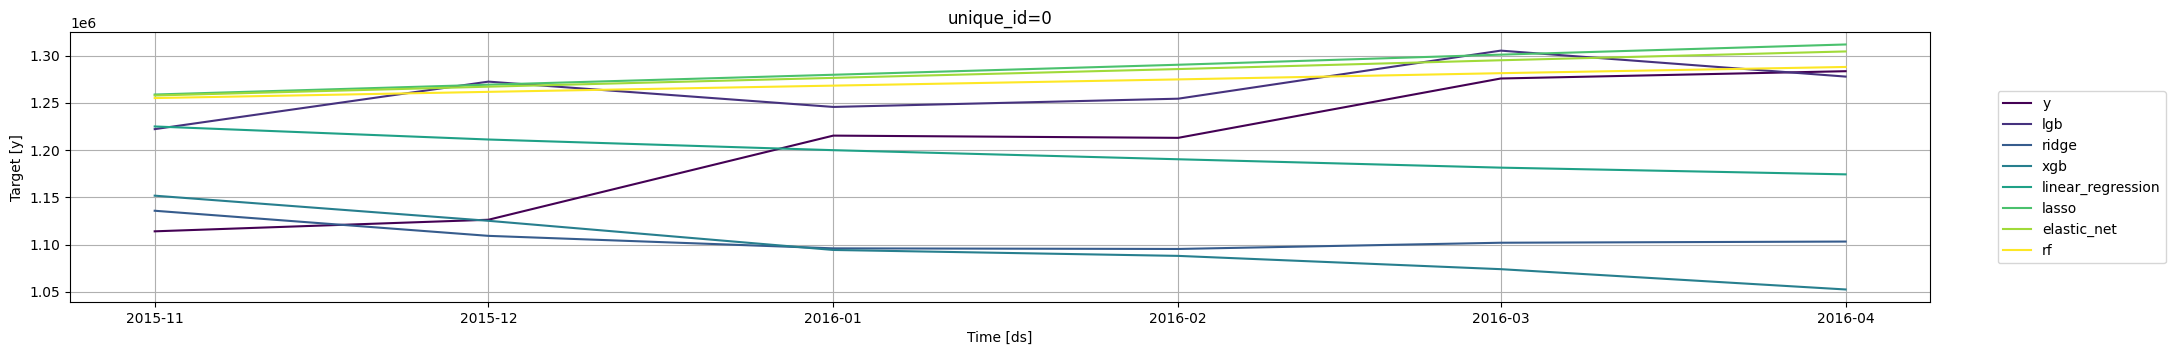

In [36]:
plot_series(df_test, preds, plot_random=False)

In [37]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [38]:
previsao_full

,ds,y,unique_id,lgb,ridge,xgb,linear_regression,lasso,elastic_net,rf
0,2015-11-01,1113976,0,1222146,1135755,1151715,1224979,1258774,1257759,1255023
1,2015-12-01,1126236,0,1272436,1109182,1125110,1211164,1269197,1267082,1261610
2,2016-01-01,1215286,0,1245640,1095946,1094248,1199876,1279707,1276404,1268197
3,2016-02-01,1212927,0,1254370,1095308,1087981,1190253,1290303,1285727,1274784
4,2016-03-01,1275746,0,1305250,1101897,1073919,1181382,1300988,1295049,1281370
5,2016-04-01,1283470,0,1277763,1103148,1052428,1174275,1311760,1304372,1287957


In [39]:
for i in list(models.keys()):
  print(f'----------------{i}-------------------')
  MAE = mean_absolute_error(previsao_full['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(previsao_full['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(previsao_full[i], previsao_full['y']))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(previsao_full['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

----------------lgb-------------------
Mean Absolute Error: 60229.666666666664
Mean absolute percentage error: 5.227226049652311
Root mean squared error: 78120.77437105532
R2: -0.4182031004214366


----------------ridge-------------------
Mean Absolute Error: 104993.83333333333
Mean absolute percentage error: 8.4438599115031
Root mean squared error: 123545.4889254696
R2: -2.54698323846388


----------------xgb-------------------
Mean Absolute Error: 119619.66666666667
Mean absolute percentage error: 9.595041637220213
Root mean squared error: 144799.71457729698
R2: -3.8723756366896795


----------------linear_regression-------------------
Mean Absolute Error: 72929.0
Mean absolute percentage error: 6.091231672693164
Root mean squared error: 82778.94467596617
R2: -0.5923741622817429


----------------lasso-------------------
Mean Absolute Error: 80514.66666666667
Mean absolute percentage error: 6.925827116965087
Root mean squared error: 93967.10559729577
R2: -1.0519040605753363


-------

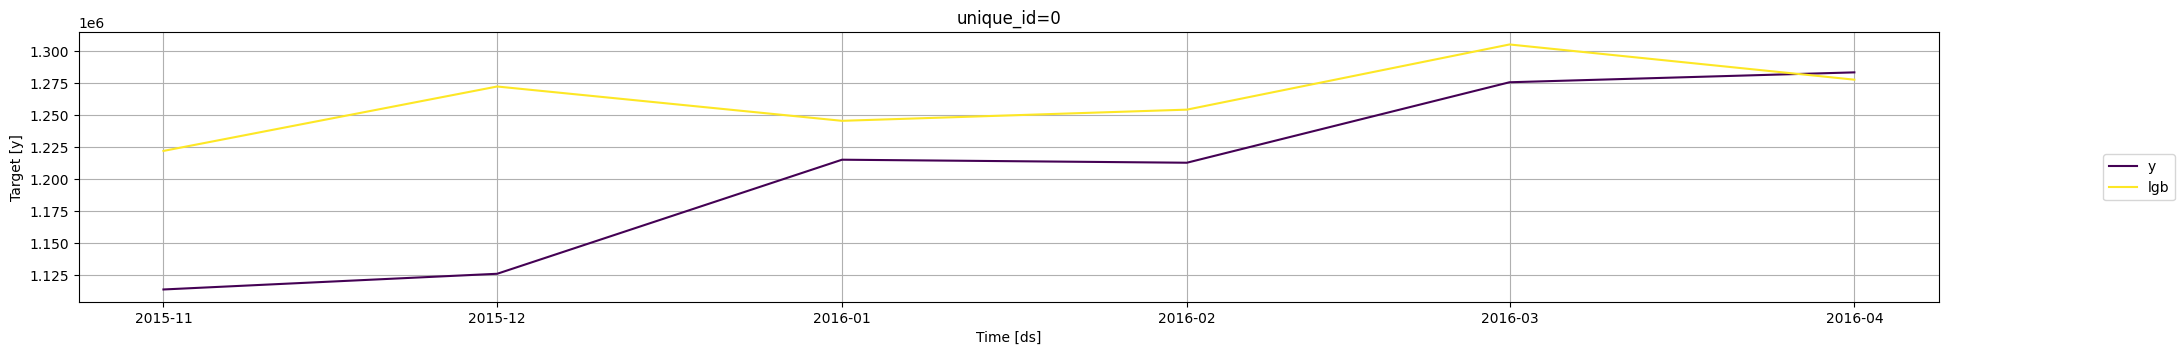

In [53]:
plot_series(df_test, preds[['unique_id', 'ds', 'lgb']], plot_random=False)

In [41]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'lgb']]

## Fazendo a previsão para os próximos 6 meses

In [42]:
dados_full = pd.concat([df_train, df_test])

In [43]:
models_full ={
    'xgb': AutoXGBoost()
        }

In [44]:
auto_mlf_full = AutoMLForecast(
    models=models_full,
    freq="MS",
    season_length=6,
)

In [45]:
auto_mlf_full.fit(
    dados_full,
    n_windows=4,
    h=6,
    num_samples=6,
)

[I 2024-07-05 16:20:26,330] A new study created in memory with name: no-name-d0c15a2b-ad2d-4648-8806-fc9daa15e0e6
[I 2024-07-05 16:20:26,632] Trial 0 finished with value: 0.030347017211230936 and parameters: {'n_estimators': 558, 'max_depth': 8, 'learning_rate': 0.024376795198947098, 'subsample': 0.5903948646972071, 'bagging_freq': 0.4812893194050143, 'colsample_bytree': 0.6813047017599905, 'min_data_in_leaf': 44.321133915006556, 'reg_lambda': 0.13620216352659412, 'reg_alpha': 0.5120378720005675, 'min_child_weight': 5, 'target_transforms_idx': 3, 'lags_idx': 0, 'lag_transforms_idx': 1}. Best is trial 0 with value: 0.030347017211230936.
[I 2024-07-05 16:20:26,922] Trial 1 finished with value: 0.05287502006479299 and parameters: {'n_estimators': 472, 'max_depth': 8, 'learning_rate': 0.0018713412964879435, 'subsample': 0.6759289191947714, 'bagging_freq': 0.22901795866814179, 'colsample_bytree': 0.9502020253446255, 'min_data_in_leaf': 52.662983853257096, 'reg_lambda': 2.0763258931120774e-0

AutoMLForecast(models={'xgb': AutoModel(model=XGBRegressor)})

In [46]:
preds_full = auto_mlf_full.predict(6)

In [47]:
for i in list(models_full.keys()):
  preds_full[i] = preds_full[i].astype(int)

In [48]:
preds_full.head(10)

,unique_id,ds,xgb
0,0,2016-05-01,1207375
1,0,2016-06-01,1223718
2,0,2016-07-01,1344376
3,0,2016-08-01,1379809
4,0,2016-09-01,1354268
5,0,2016-10-01,1449658


# Exportando os arquivos

# Exportando o pickle

In [49]:
with open('ModelosPKL/valores.pkl', 'wb') as f:
    pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [50]:
preds_full.to_csv('previsao_valor.csv', index=False)

# Validação

In [51]:
tabela_validacao.to_csv('validacao_valor.csv', index=False)